In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import re

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

## Import Data

In [2]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/data_open_trails.csv', parse_dates=True, index_col=0)

In [3]:
pd.set_option('display.max_rows', 500)

#### Drop the NaNs and inf scale data

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

In [5]:
ref_column = 'open_trails'

#### Scale the ref column

In [6]:
sc_skiers = scale_skiers(df, (0,100), ref_column)
sc_skiers = [round(crowd, 0) for crowd in sc_skiers]
df['open_trails'] = sc_skiers

### Create a training and holdout set

In [7]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
#df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

## Forward selection

In [8]:
lin_regr = linear_model.LinearRegression()

In [9]:
features = list(df_tr.columns.values)
features.remove(ref_column)

In [10]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features].values

In [11]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos][ref_column]
y_tr_apr = df_tr.iloc[apr_pos][ref_column]

In [12]:
#leave_out = ['day_5', 'midweek', 'day_0', 'xmas', 'day_4', 'day_0', 'spring_break']
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [273]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  ln_tot_snow , RMSE:  16.7 #: 1
Next best Feature:  days_since_start_sq , RMSE:  12.9 #: 2
Next best Feature:  days_since_start , RMSE:  12.1 #: 3
Next best Feature:  days_since_start_spring_break_sq , RMSE:  12.0 #: 4
Next best Feature:  6day_snow_tot_sq , RMSE:  11.9 #: 5
Next best Feature:  tot_snow_spring_break_sq , RMSE:  11.9 #: 6
Next best Feature:  2day_snow_tot_fri_sq , RMSE:  11.9 #: 7
Next best Feature:  2day_snow_tot_fri_sqrt , RMSE:  11.8 #: 8
Next best Feature:  6day_snow_tot_xmas_sq , RMSE:  11.7 #: 9
Next best Feature:  2day_snow_tot_sat_sq , RMSE:  11.7 #: 10
Next best Feature:  3day_snow_tot_sat_sq , RMSE:  11.7 #: 11
Next best Feature:  4day_snow_tot_sat_sq , RMSE:  11.7 #: 12
Next best Feature:  day_4_spring_break_sqrt , RMSE:  11.7 #: 13
Next best Feature:  day_4_fri_sqrt , RMSE:  11.6 #: 14
Next best Feature:  6day_snow_tot_fri_sq , RMSE:  11.6 #: 15
Next best Feature:  5day_snow_tot_fri , RMSE:  11.6 #: 16
Next best Feature:  ln_new_24_fri , RM

In [14]:
fs_features = ['ln_tot_snow', 'days_since_start_sq', 'days_since_start', 'days_since_start_spring_break_sq', '6day_snow_tot_sq', 'tot_snow_spring_break_sq', '2day_snow_tot_fri_sq', '2day_snow_tot_fri_sqrt', '6day_snow_tot_xmas_sq', '2day_snow_tot_sat_sq', '3day_snow_tot_sat_sq', '4day_snow_tot_sat_sq', 'day_4_spring_break_sqrt', 'day_4_fri_sqrt', '6day_snow_tot_fri_sq', '5day_snow_tot_fri', 'ln_new_24_fri', 'new_24_fri_sqrt', 'ln_4day_snow_tot_fri', 'ln_3day_snow_tot_fri', 'week_snow_tot_fri_sq', '2day_snow_tot_mon_sq', 'before_xmas_mon', '6day_snow_tot_mon_sq', 'thanksgiv_midweek_sqrt', 'month_12_midweek', 'week_snow_tot_sat_sq', 'ln_6day_snow_tot_sat', 'pres_day_fri_sq', '2day_snow_tot_sat_sqrt', 'ln_2day_snow_tot_sat', 'thanksgiv_mon_sqrt', 'week_snow_tot_xmas_sq', 'day_6_xmas_sq', 'thanksgiv_fri_sq']

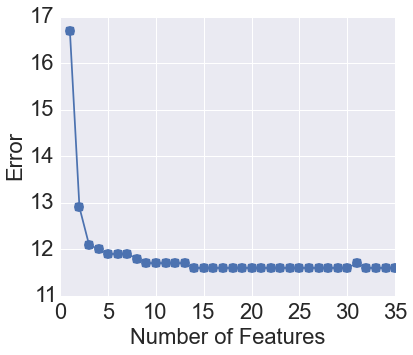

In [274]:
plot_error_vs_features(RMSE, 'none', 'none')

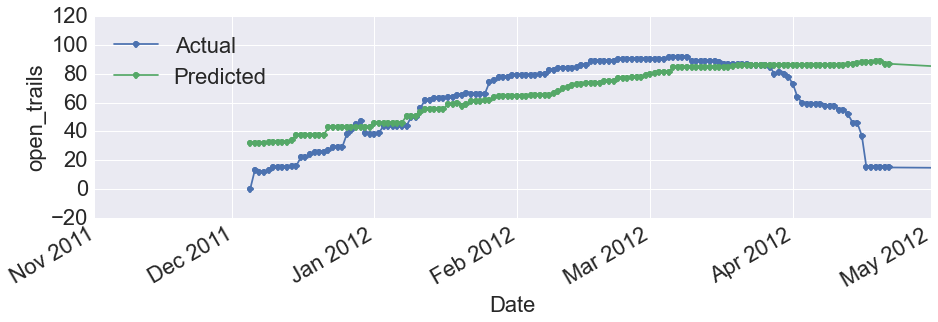

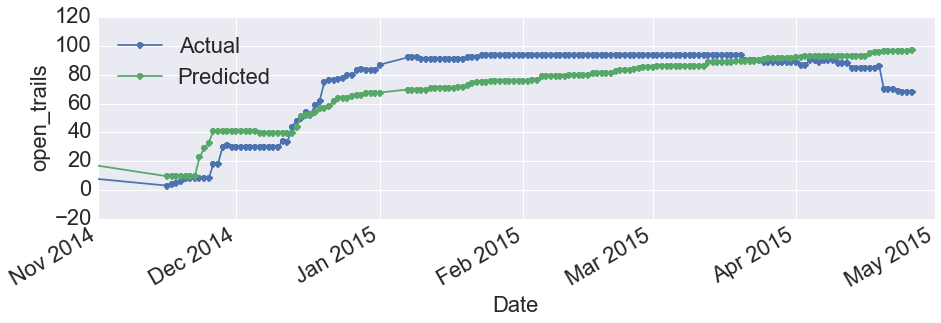

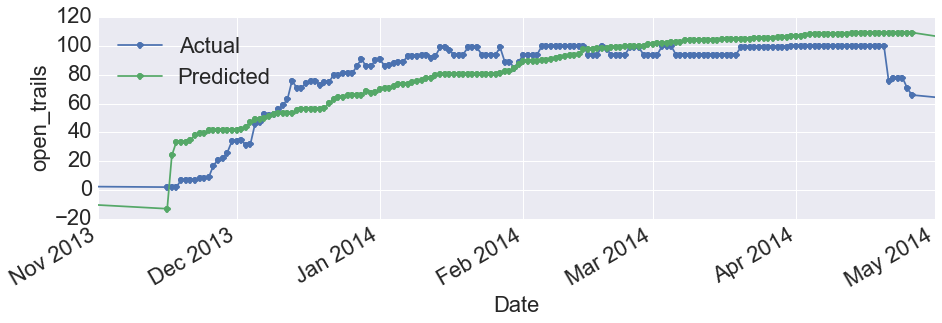

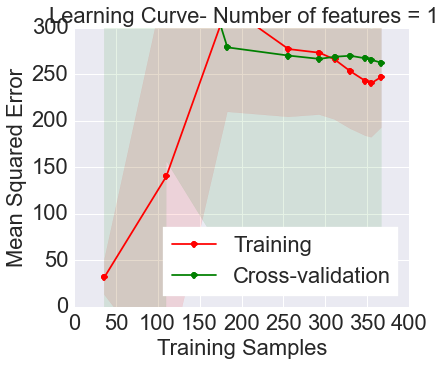

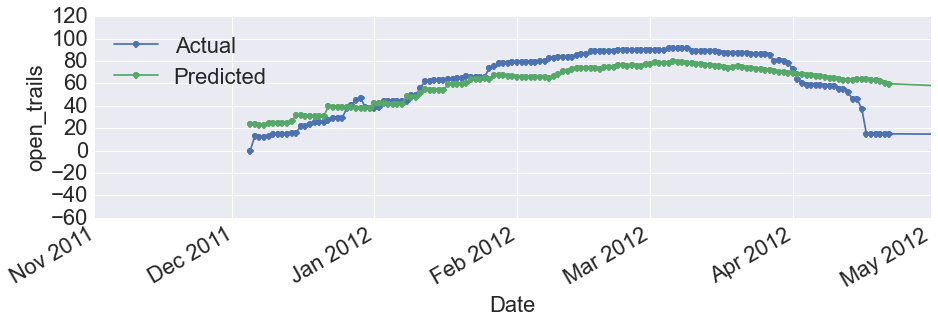

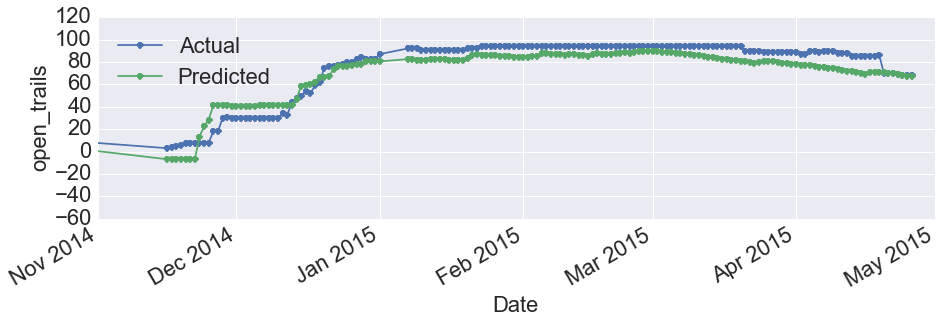

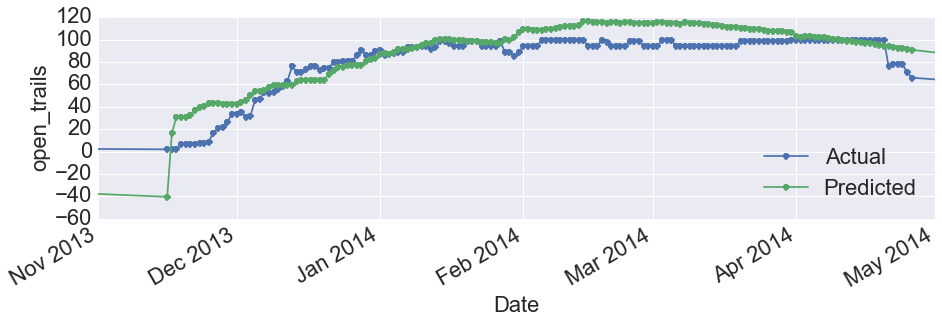

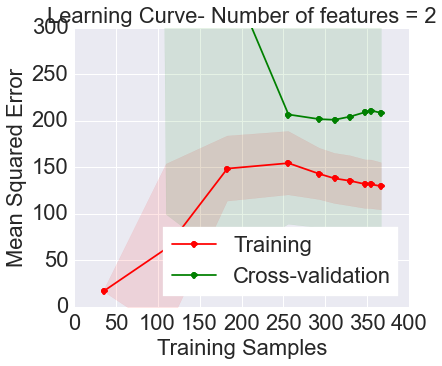

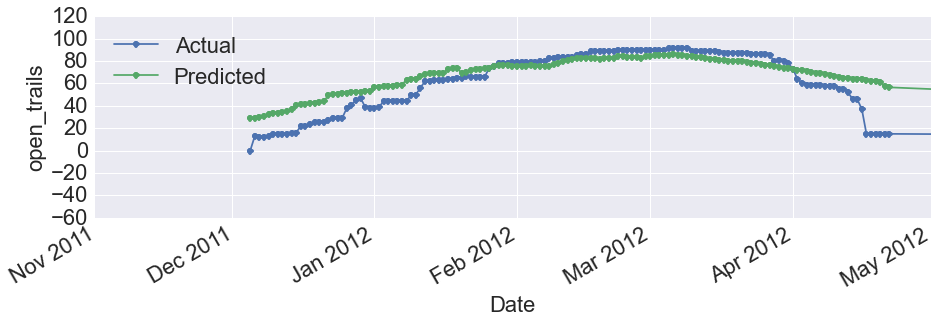

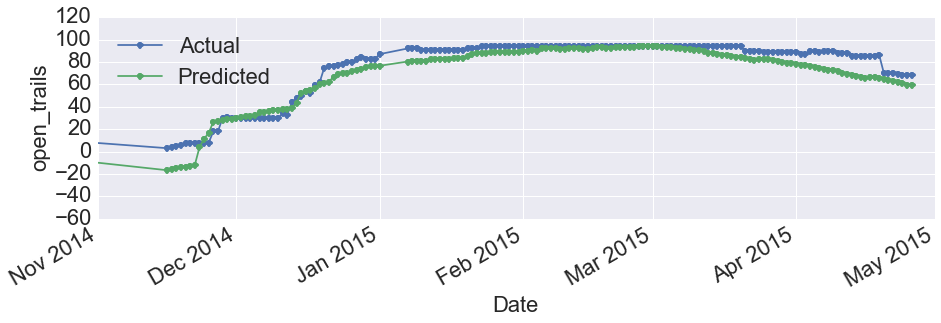

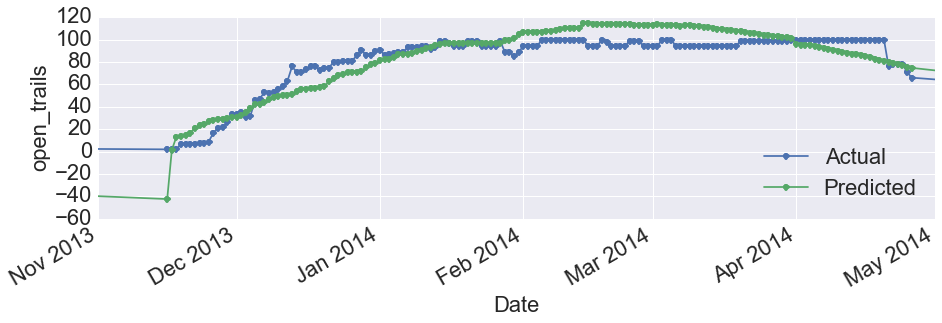

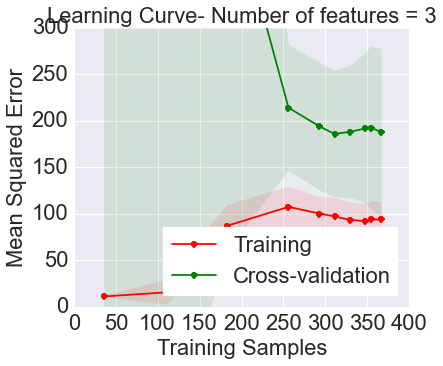

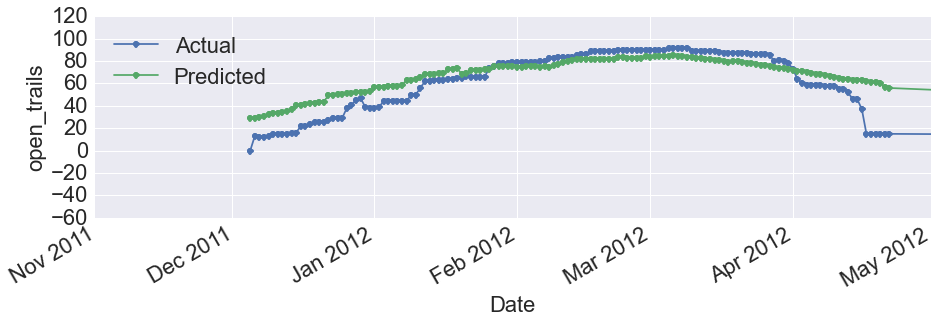

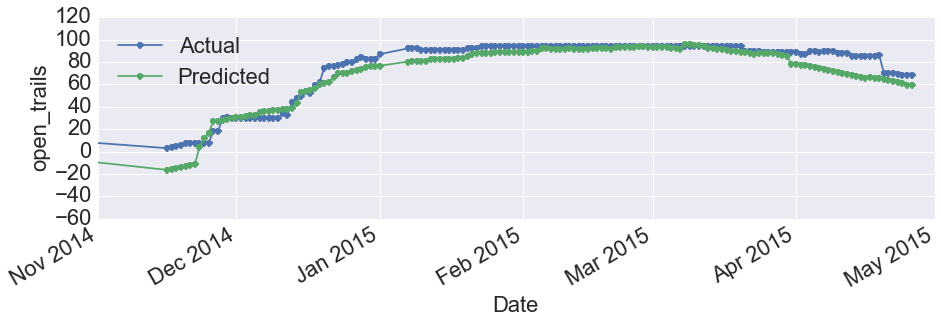

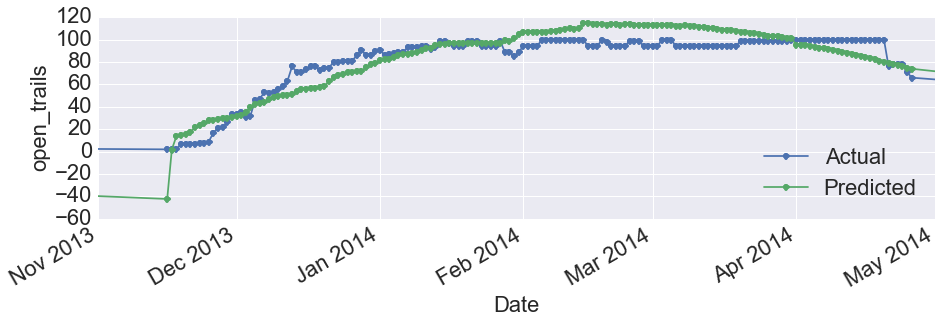

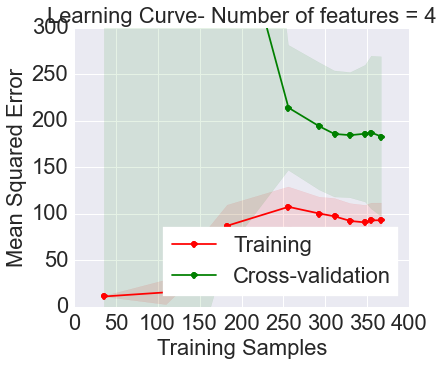

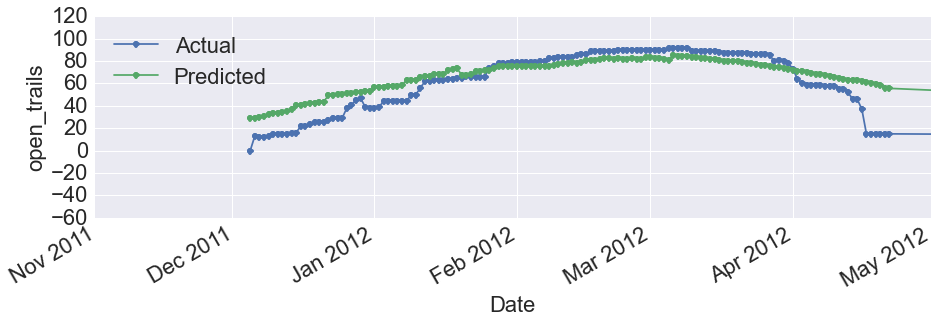

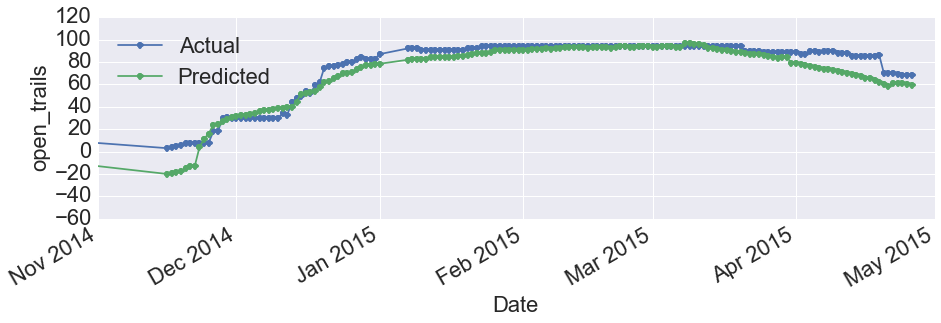

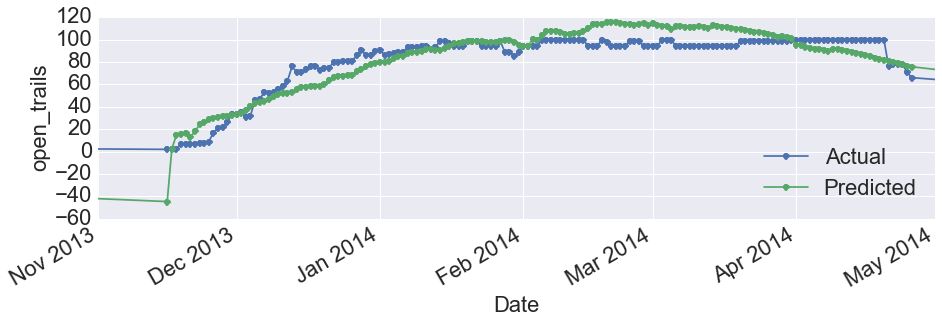

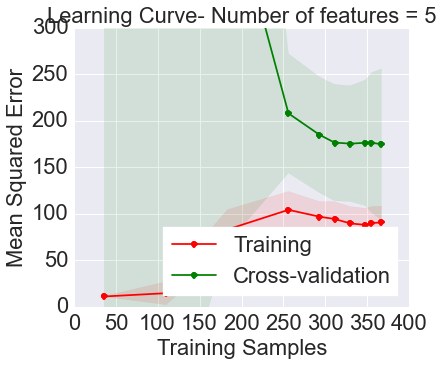

In [276]:
i = 1
while i < 6:
    num_good_feat = i
    df_reg = pd.concat([df_tr[ref_column], df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr[ref_column].values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4), ref_column)
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4), ref_column)
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4), ref_column)
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,300), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

In [13]:
fs_features = ['ln_tot_snow', 'days_since_start_sq', 'days_since_start', 'days_since_start_spring_break_sq', '6day_snow_tot_sq', '2day_snow_tot_fri_sq', '6day_snow_tot_fri_sq', '6day_snow_tot_xmas_sq', 'tot_snow_spring_break_sq', '2day_snow_tot_fri_sqrt', '5day_snow_tot_fri', 'week_snow_tot_fri_sq', '2day_snow_tot_mon_sq', 'before_xmas_mon_sq', '6day_snow_tot_midweek', 'ln_week_snow_tot_midweek', 'thanksgiv_midweek', 'month_12_midweek_sqrt', 'thanksgiv_fri_sq', '3day_snow_tot_fri', 'week_snow_tot_sat_sq', 'ln_2day_snow_tot_sat', '2day_snow_tot_sat_sqrt', '6day_snow_tot_sat', 'thanksgiv_mon_sq', 'ln_3day_snow_tot_sat', 'ln_4day_snow_tot_sat', 'pres_day_fri_sqrt', 'day_4_spring_break_sq', 'ln_4day_snow_tot', 'new_24_mon_sqrt', '3day_snow_tot', 'day_5_spring_break_sqrt', 'month_2_fri', 'ln_new_24_fri']

In [14]:
num_feat = 3
best_features = fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 12.1 ,  Holdout RMSE: 19.3


### Cross Validation Fit

In [15]:
ref_column

'open_trails'

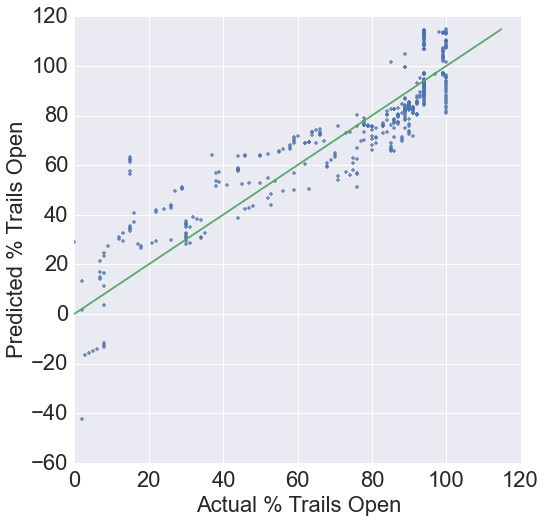

In [16]:
fitted_vs_ref_plot(df_cv_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

### Holdout Fit

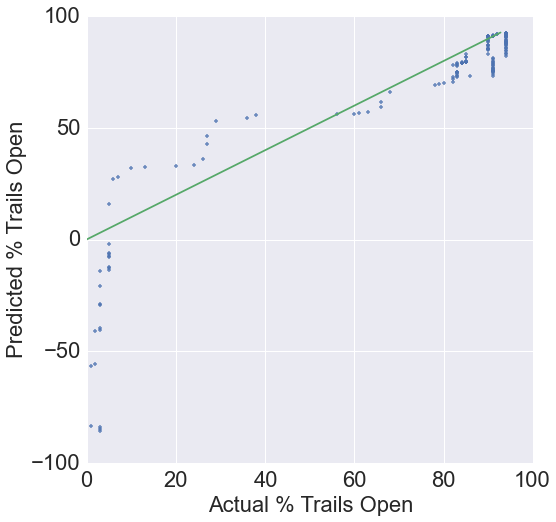

In [17]:
fitted_vs_ref_plot(df_H_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

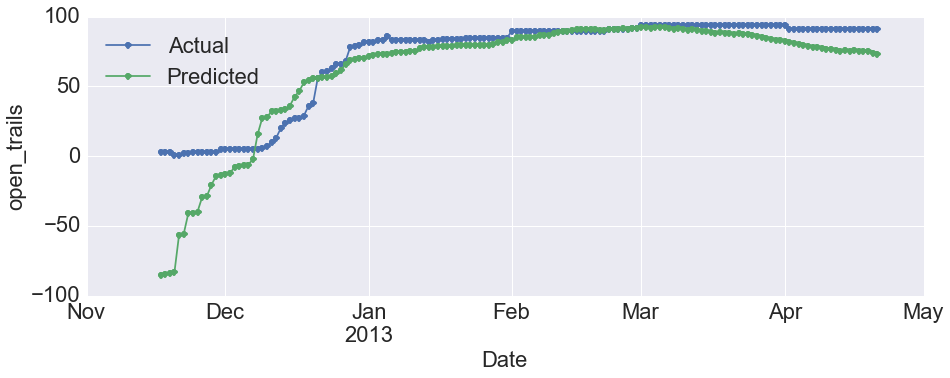

In [18]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1, (15,5), ref_column)

### Lasso

In [290]:
features = list(df.columns.values)
features.remove(ref_column)

In [291]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features, ref_column)

In [292]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 10.0


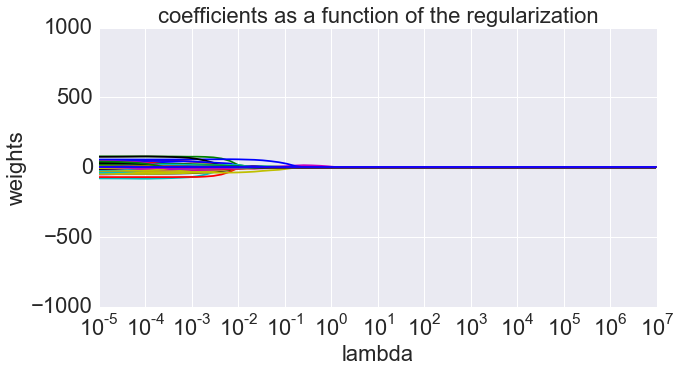

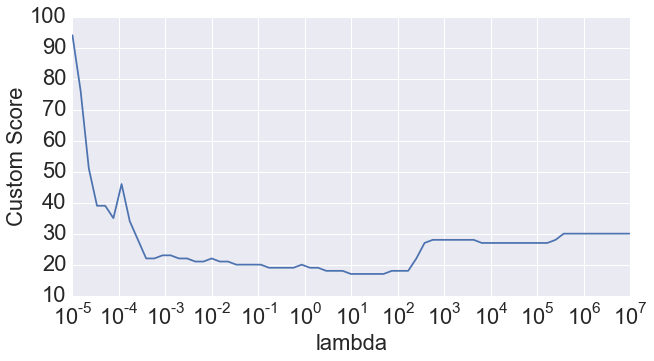

In [293]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [294]:
clf = linear_model.Lasso(alpha=best_lambda)

In [295]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

CV RMSE: 17.5 ,  Holdout RMSE: 10.5


#### Plot the holdout lasso prediction vs the reference data

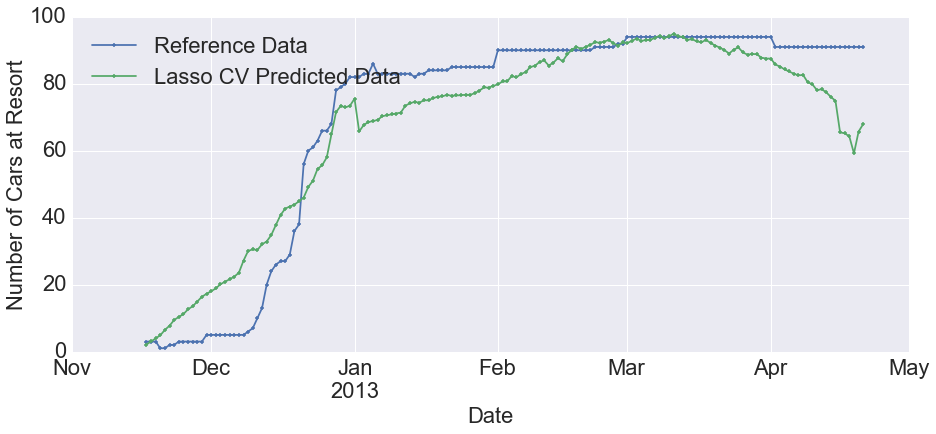

In [296]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [19]:
features = fs_features

In [20]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features]
y_h = df_h[ref_column].values

#### Fit the random forest regressor and find cross-validation stats

In [21]:
rfr = RandomForestRegressor(n_estimators = 500, oob_score = True, n_jobs = -1)

In [22]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

CV RMSE: 11.2 ,  Holdout RMSE: 5.1


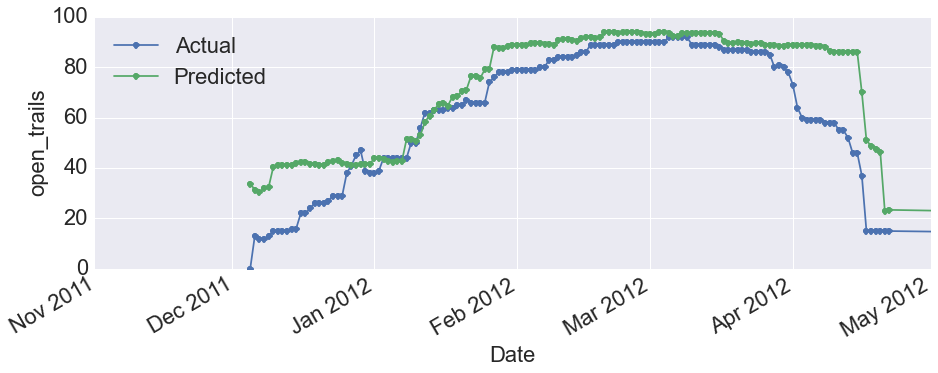

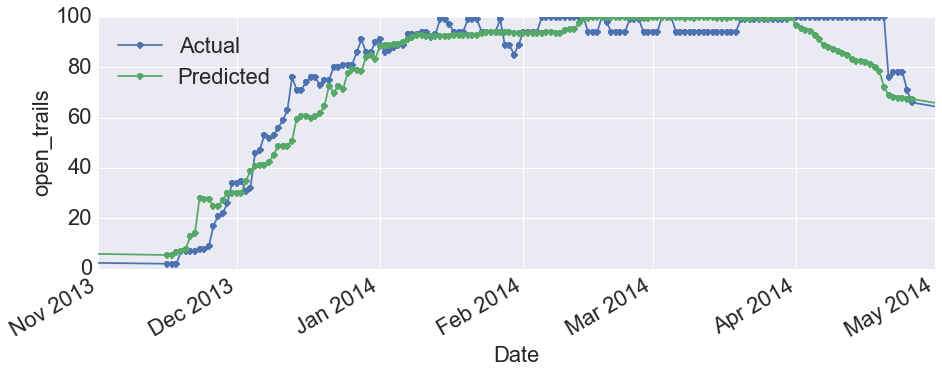

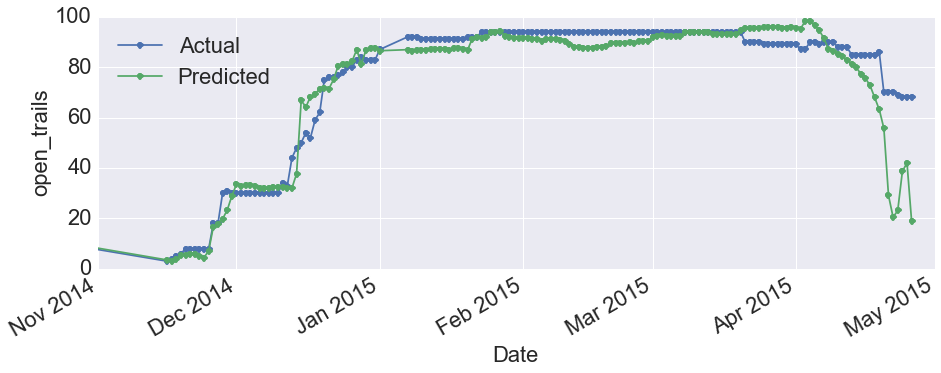

In [23]:
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)

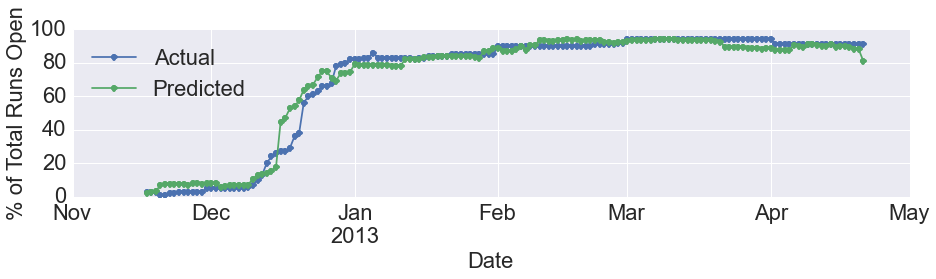

In [24]:
plot_fitted_and_ref_vs_time(df_rf_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1200, (15,3), '% of Total Runs Open')

In [28]:
X_fut = df_fut[fs_features]
df_fut = df.ix[datetime.datetime(2015,5,1):]
df_cv = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]

In [36]:
df_pred = run_bootstrap_model(df_cv, rfr, fs_features, X_fut, ref_column)

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:688: DeprecationWarning: Bootstrap will no longer be supported as a cross-validation method as of version 0.15 and will be removed in 0.17
  "will be removed in 0.17", DeprecationWarning)


In [37]:
df_fut = add_pred_and_conf_int_to_df(df_pred, df_fut)

functions.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['pred'] = pred_mean
functions.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['st_dev'] = pred_std
functions.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['lower'] = df_fut['pred'] - df_fut['st_dev']*2
functi

### Export Linear Model with Best Features to Model

In [353]:
df_all = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]
X = df_all[fs_features]
y = df_all[ref_column]
mdl = rfr.fit(X,y)
df_fut = df.ix[datetime.datetime(2015,11,1):]

In [355]:
pred_h = mdl.predict(X)

In [356]:
df_all['pred'] = pred_h

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [357]:
df_all.head()

,new_24,open_trails,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot,day_0,...,before_xmas_fri_sq,before_xmas_fri_sqrt,ln_before_xmas_fri,before_xmas_sat_sq,before_xmas_sat_sqrt,ln_before_xmas_sat,before_xmas_mon_sq,before_xmas_mon_sqrt,ln_before_xmas_mon,pred
2011-12-05,1,0,20,4,4,4,4,4,4,1,...,0,0,0,0,0,0,0,0,0,2.354
2011-12-06,0,13,20,4,1,4,4,4,4,0,...,0,0,0,0,0,0,0,0,0,10.068
2011-12-07,0,12,20,4,0,1,4,4,4,0,...,0,0,0,0,0,0,0,0,0,11.400
2011-12-08,0,12,20,4,0,0,1,4,4,0,...,0,0,0,0,0,0,0,0,0,12.426
2011-12-09,1,13,21,5,1,1,1,2,5,0,...,0,0,0,0,0,0,0,0,0,13.636


In [358]:
X_fut = df_fut[fs_features]
pred_fut = mdl.predict(X_fut)
df_fut['pred'] = pred_fut

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [39]:
df_out = pd.concat([df_all, df_fut], axis=0) 

NameError: name 'df_all' is not defined

In [41]:
df_dow = day_of_week_col(df_fut)
df_fut = pd.concat([df_fut, df_fut['day_of_week']], axis=1)

# Export Data

In [42]:
df_fut.to_csv('../webpage_ski/df_runs_open.csv')